# Get ROIs for each subject

This notebook corresponds to the section **Generation of Regions of Interest (ROIs) in the Subject's Native Space**, which utilizes the `generation_subs_rois` function from the `MEEG_fMRI_whole_compa_script.py` script.

It provides a detailed guide for creating subject-specific atlases by integrating three distinct brain atlases: **HOCPAL**, **AAL**, and **Schaefer2018**. The primary objective is to coregister the selected atlas from the MNI152NLin6Asym template into the subject's native space, thereby facilitating precise region-of-interest (ROI) analysis.

This notebook replicates the functionality of the `create_subject_rois` function found in `roi_utils.py`, performing the same tasks with detailed, step-by-step instructions.

### Steps Involved:

1. **Select Subject and Atlas**  
   Start by choosing the desired subject and atlas from the available options.

2. **Load T1-Weighted Anatomical Data**  
   Define the path to the subject's normalized T1-weighted anatomical data and load the image.

3. **Load and Resample the Atlas**  
   Load the selected atlas along with its corresponding labels. Resample the atlas to match the subject's T1 image dimensions and affine transformation.

4. **Save Resampled Atlas**  
   Save the resampled atlas in the output directory if it doesn't already exist to avoid redundant processing.

5. **Handle Missing Labels (HOCPAL Atlas)**  
   If using the HOCPAL atlas, manage any missing labels by adding them to the labels DataFrame and saving the updated file.

6. **Map ROI Indices**  
   Retrieve the atlas indices based on the chosen atlas type and map them to the corresponding ROIs for the specified tasks.

7. **Transform Atlas to Subject Space**  
   Perform the transformation of the atlas from template space to the subject's native space for accurate spatial alignment.

8. **Optional Plotting**  
   If `plotting=True`, visualize the resampled atlas in the subject's space and save the plots.

9. **Create and Save ROIs**  
   Generate and save the ROIs for the specified tasks in the subject's native space. Optionally, plot the ROIs if `plotting=True`.

## Import the necessary libraries 

In [1]:
from nilearn.plotting import view_img, plot_anat, plot_roi
from nilearn.image import resample_img, new_img_like
from nilearn import datasets

import nibabel as nib
from pathlib import Path
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt

# Personal Imports
# Add the directory that contains the utils package to sys.path
sys.path.append(str(Path('..').resolve()))

from utils.roi_utils import get_index_by_name, create_roi, transform_atlas_to_native_space
from utils.utils import *

## Path to the dataset

Make sure to update the `config.py` file paths according to your system’s directory structure.

In [38]:
from config import LOCAL_DIR, PATH_TO_MRI_DATA, PATH_TO_TPLFLOW

path_to_data = PATH_TO_MRI_DATA
local_dir = LOCAL_DIR
path_tflow_data = PATH_TO_TPLFLOW

## Get the subjects names for this study

**Subject Exclusions and Issues:**

- **Subjects 1 and 2**: Excluded from analysis because their results in the native space are not available.
- **Subject 11**: Removed due to issues encountered during data acquisitions.
- **Subject 10**: Not available.

In [39]:
# Create a list of subjects from 'sub-03' to 'sub-17'
subjects = [f"sub-{i:02}" for i in range(3, 18) if i not in [11, 10]]

# Print the updated list to verify
print(subjects)

['sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-12', 'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17']


## Load the tpl-MNI152NLin6Asym (to also have the atlas with it)

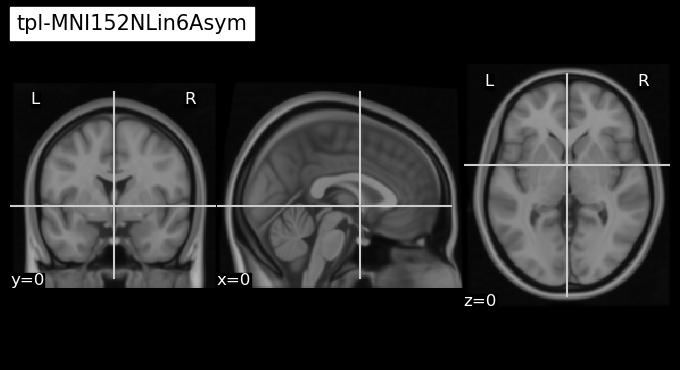

In [44]:
# Download if not done yet
# from templateflow import api as tflow
# tflow.get('MNI152NLin6Asym')

# Load the anatomical template
tplMNI152NLin6Asym = nib.load(Path(path_tflow_data) / 'tpl-MNI152NLin6Asym_res-01_T1w.nii.gz')

# Plot the anatomical template with enhanced parameters
plot_anat(tplMNI152NLin6Asym,
          cut_coords=(0, 0, 0),  # Adjust this as needed
          title='tpl-MNI152NLin6Asym') # Title of the plot

After verification in MRICON, it appears that the template closest to the one used in SPM is the MNI152NLin6Asym. This conclusion was reached by overlaying the templates and confirming their alignment. This finding is consistent with the discussion in this forum post: [Neurostars Forum](https://neurostars.org/t/hammersmith-atlas-uses-the-mni152-template-but-array-sizes-are-different/27577/2).

## Compare the T1 MNI of the subject and the template

Be sure to update the variable `sub` to select your subject.

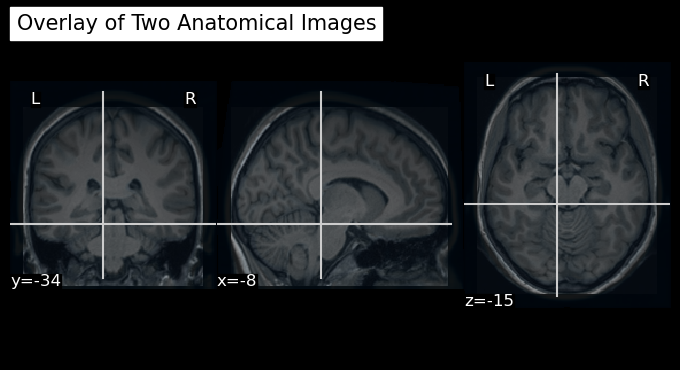

In [41]:
# Choose a subject
sub = subjects[0]

# Define the derivatives directory for this subject 
sub_derivatives_dir = Path(local_dir) / 'derivatives' / sub

# Define the path to the normalized T1-weighted anatomical data
anat_outdir = sub_derivatives_dir / 'anat'
T1_MNI_path = anat_outdir / f"{sub}_space-spmMNI_T1w.nii.gz"
T1_MNI_img = nib.load(T1_MNI_path)  # Load the T1 image

# Plot the first anatomical image
display = plot_anat(T1_MNI_img, title='Overlay of Two Anatomical Images')

# Add the second anatomical image as an overlay
display.add_overlay(tplMNI152NLin6Asym, cmap='Blues_r', alpha=0.1)

# Show the plot
plt.show()
plt.close()

## Load an atlas from the template flow directory of this template

Five atlases can be loaded for analysis:

1. **HOCPAL Atlases:**
   - **HOCPAL_desc-th0_dseg**: Harvard Oxford atlas with left and right hemispheres separated, providing regions with a standard thickness around the gray matter.
   - **HOCPAL_desc-th25_dseg**: Similar to the above but with thinner regions around the gray matter, offering more precise segmentation.

2. **Schaefer2018 Atlases:**
   - **Schaefer2018_desc-100Parcels7Networks_dseg**: An atlas that divides the brain into 100 parcels based on 7 functional networks.
   - **Schaefer2018_desc-100Parcels17Networks_dseg**: An atlas that divides the brain into 100 parcels based on 17 functional networks.

3. **AAL Atlas:**
   - **AAL**: Automated Anatomical Labeling atlas defined in the MNI152 space.

### Important Considerations:

- The **HOCPAL** atlases provide options with different thicknesses (th0 and th25), with th25 being the thinner option for more refined segmentation.
- The **AAL** atlas is aligned with the MNI152 template. It is crucial to ensure that the normalized T1 image and the AAL atlas are aligned with the same template, especially since the specific template used for normalization is currently unknown. Verification of this alignment is necessary to ensure accurate results.

*Don’t forget to update the `atlas` variable.*

In [42]:
# List of the available atlas
atlas_available = ['HOCPALth0', 'HOCPALth25', 'Schaefer7',
                   'Schaefer17', 'AAL']

atlas_mapping = {
    'HOCPALth0': 'HOCPAL_desc-th0_dseg',
    'HOCPALth25': 'HOCPAL_desc-th25_dseg',
    'Schaefer7': 'Schaefer2018_desc-100Parcels7Networks_dseg',
    'Schaefer17': 'Schaefer2018_desc-100Parcels17Networks_dseg',
    'AAL': 'AAL'
}

# Choose the atlas
atlas = atlas_available[0]

print(f"Creating ROIs in {sub} space from atlas {atlas}.")

atlas_id = atlas_mapping.get(atlas, atlas)

# Define labels name based on atlas
labels_name = 'HOCPAL_dseg' if 'HOCPAL' in atlas_id else atlas_id

if atlas != 'AAL':
    # Load atlas and labels from predefined paths
    atlas_path = Path(path_tflow_data) / f'tpl-MNI152NLin6Asym_res-01_atlas-{atlas_id}.nii.gz'
    path_atlas_labels = Path(path_tflow_data) / f'tpl-MNI152NLin6Asym_atlas-{labels_name}.tsv'
    labels_df = pd.read_csv(path_atlas_labels, sep='\t')  # Load the labels
else:
    # Fetch AAL atlas if it's not downloaded
    from nilearn import datasets
    dataset_aal = datasets.fetch_atlas_aal()
    atlas_path = dataset_aal.maps

# Load the atlas image
atlas_img = nib.load(atlas_path)
    
        

Creating ROIs in sub-03 space from atlas HOCPALth0.


### Resample the atlas in the subject anat space

In [43]:
# Resample the atlas to match T1 image dimensions and affine transformation
atlas_img_resampled = resample_img(
    atlas_img, target_affine=T1_MNI_img.affine, 
    target_shape=T1_MNI_img.shape, interpolation='nearest' if atlas == 'AAL' else 'continuous'
)
    
# Define the output directory for the resampled atlas
atlas_sub_outdir = sub_derivatives_dir / 'anat' / f'atlas-{atlas}'
atlas_sub_outdir.mkdir(parents=True, exist_ok=True)

# Define the path where the resampled atlas image will be saved
if atlas != 'AAL':
    atlas_sub_temp_space_path = atlas_sub_outdir / f"{sub}_space-MNI152NLin6Asym_atlas-{atlas}.nii.gz"
else:
    atlas_sub_temp_space_path = atlas_sub_outdir / f"{sub}_space-MNI152_atlas-{atlas}.nii.gz"

# Save the resampled atlas image to the specified path
if not atlas_sub_temp_space_path.exists():
    nib.save(atlas_img_resampled, atlas_sub_temp_space_path)

## Test the atlas onto the subject anat

C:\Users\lilia.ponselle\AppData\Local\anaconda3\envs\mne\Lib\site-packages\numpy\core\fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



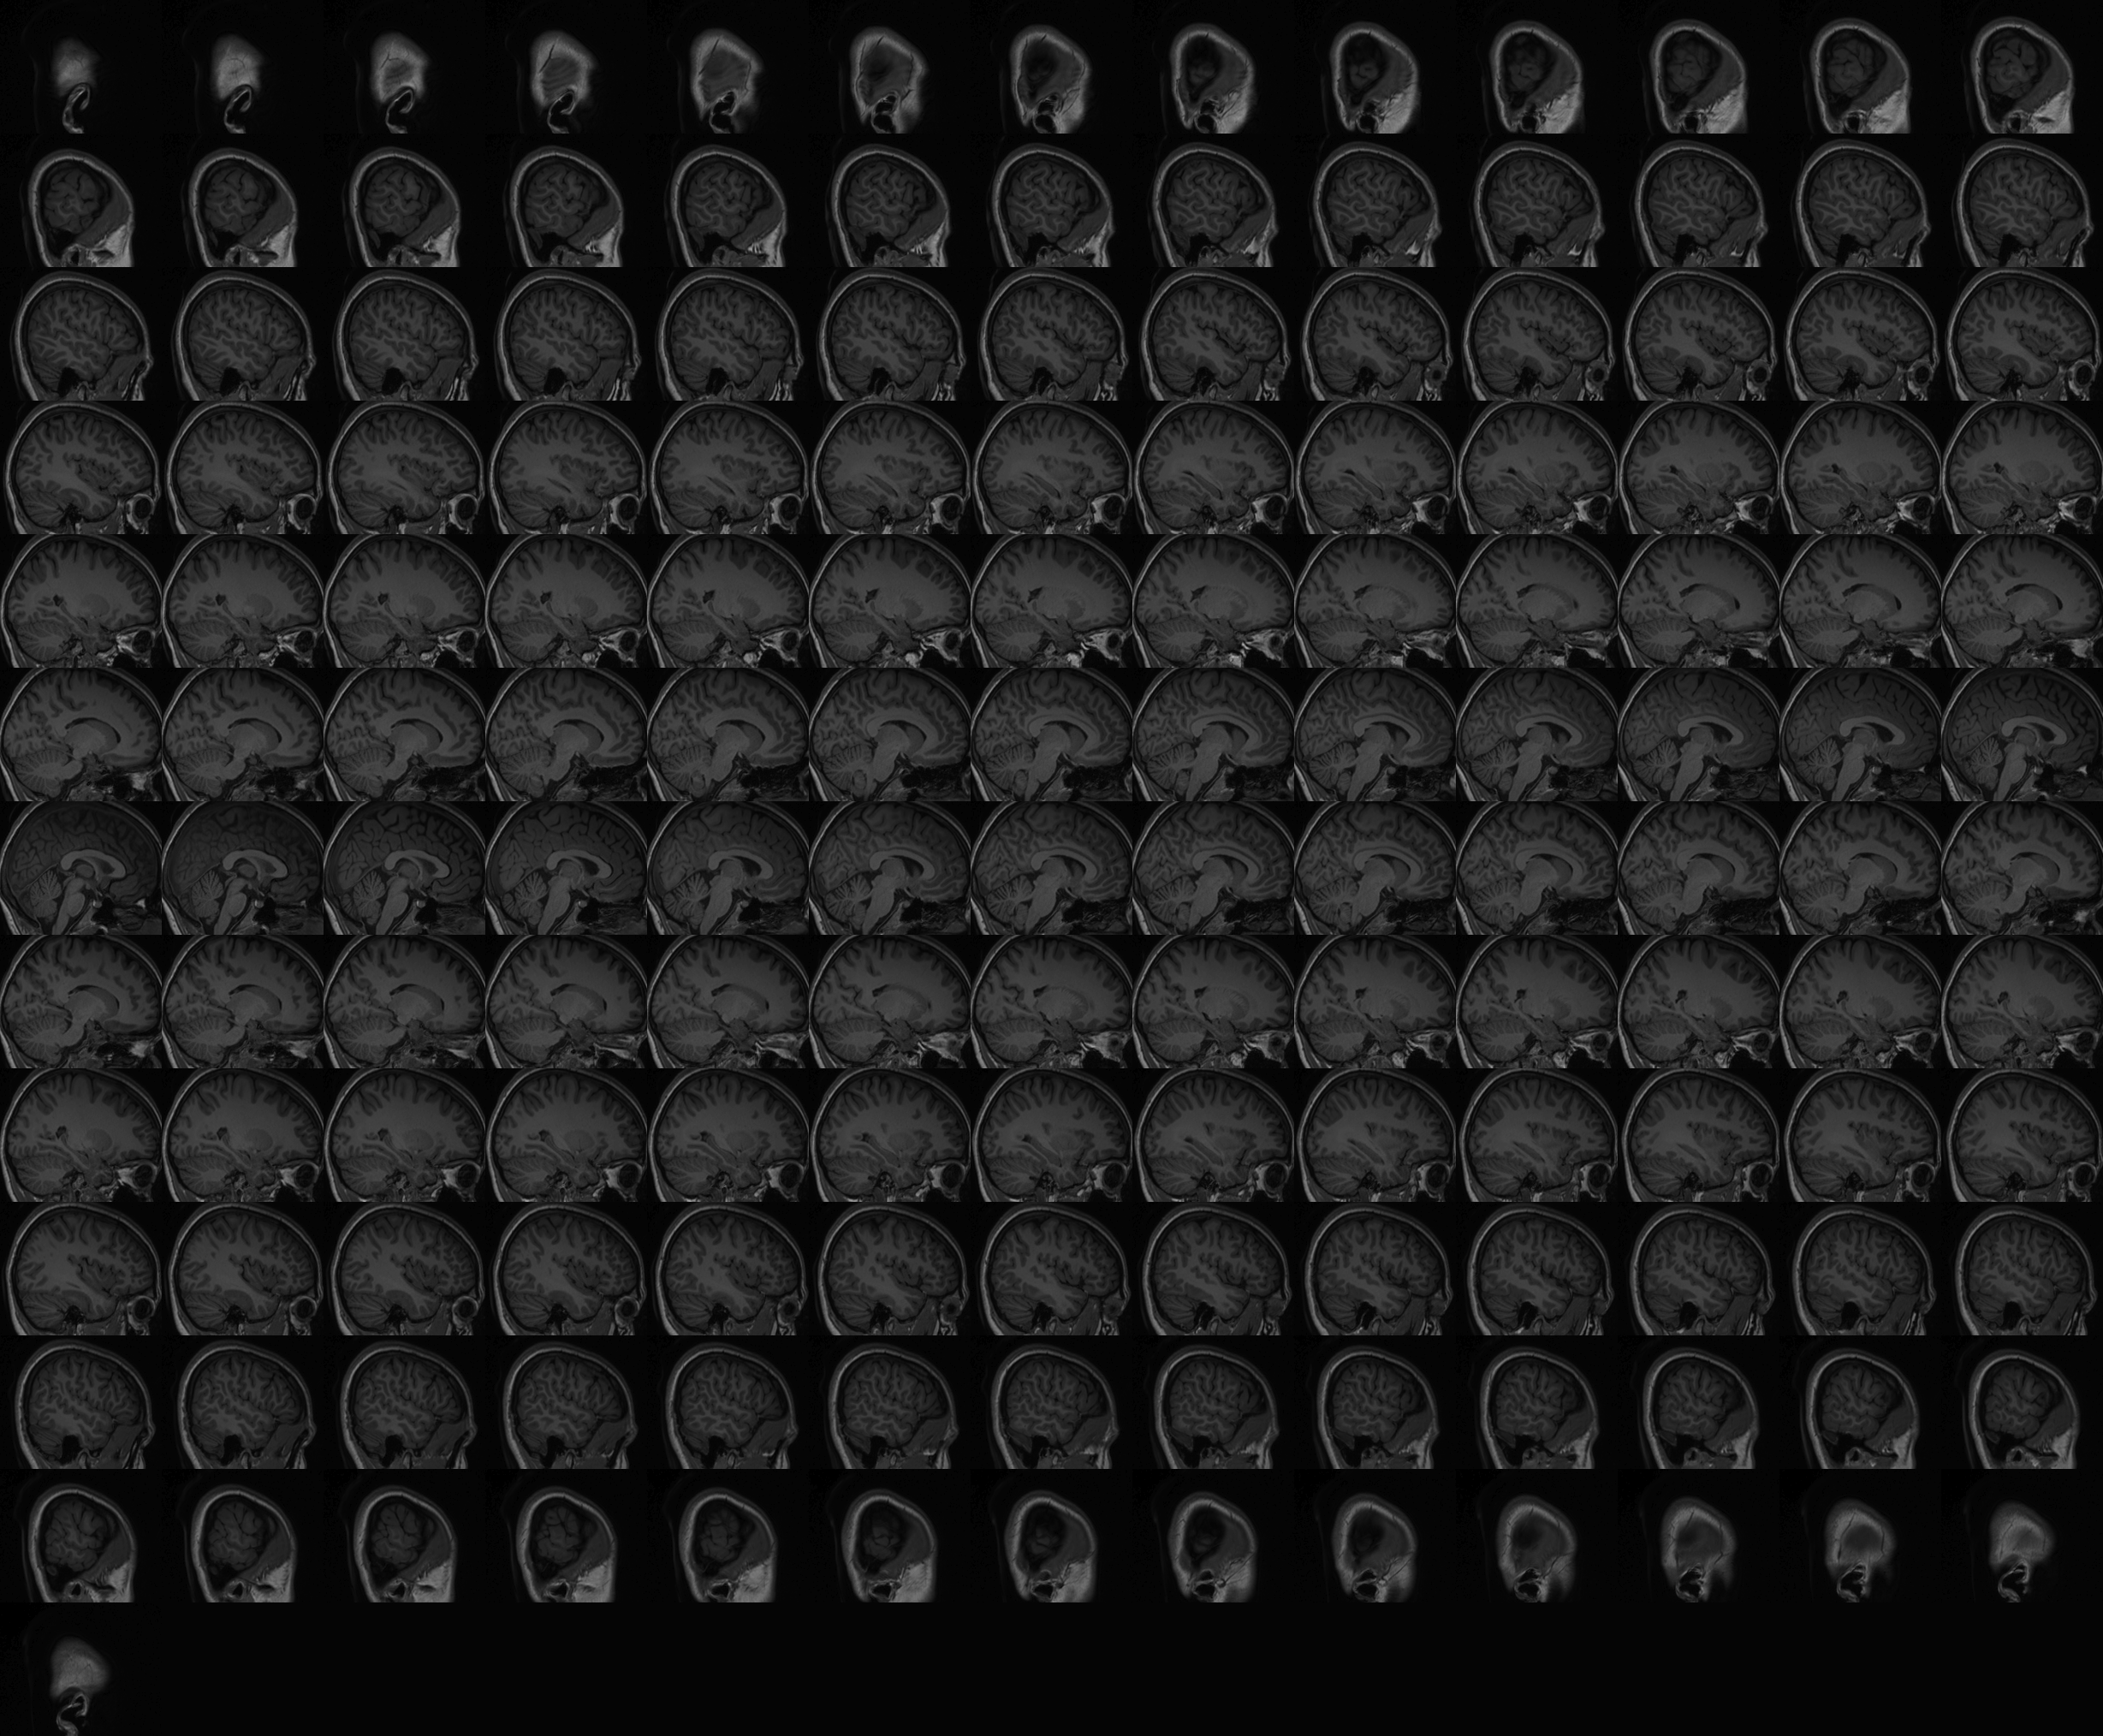
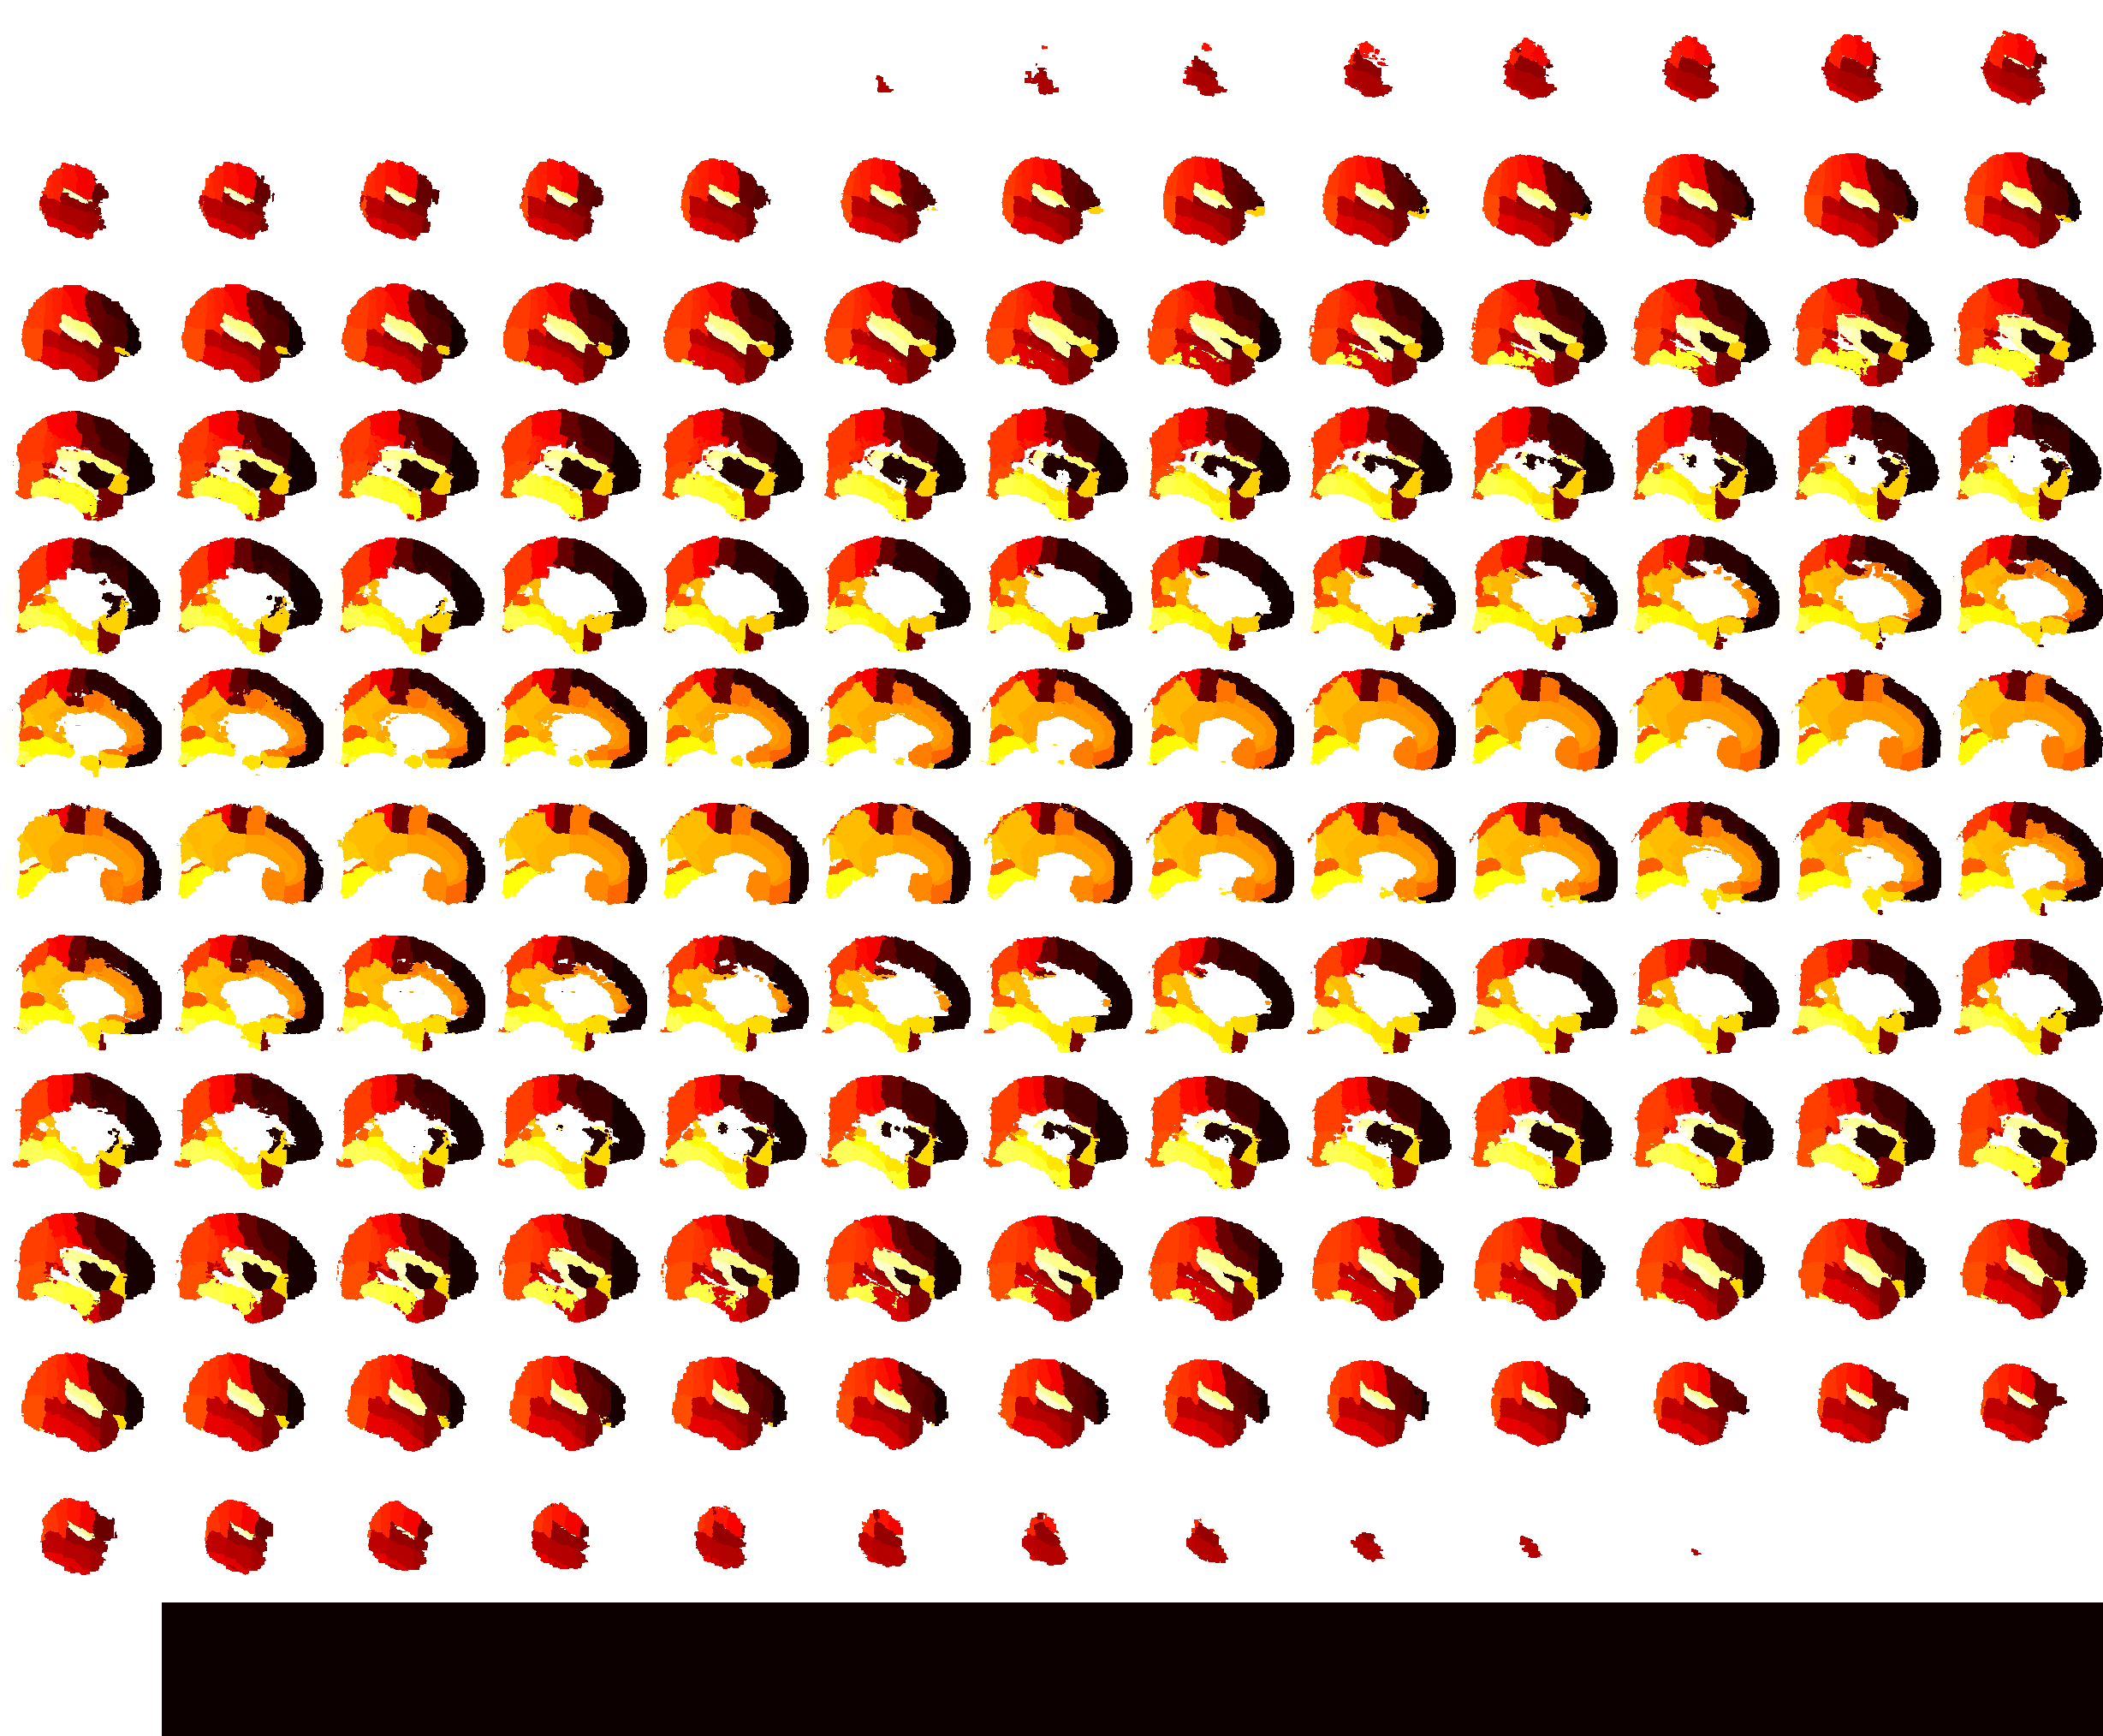

In [29]:
# Plot
view_img(atlas_img_resampled,  bg_img = T1_MNI_img, title=f"{atlas} atlas", opacity = 0.15)

## Get the ROIs definition depending of the atlases

In [30]:
from utils.roi_utils import ATLAS_REGIONS

atlas_regions = ATLAS_REGIONS

## Make a dictionnary with the parcels wanted for each task depending on the atlas

**Warnings:**

In the `tpl-MNI152NLin6Asym_atlas-HOCPAL_dseg.tsv` file, the following lines were missing:
- 42: 'Left Lateral Occipital Cortex Sup',
- 43: 'Right Lateral Occipital Cortex Sup',
- 44: 'Left Lateral Occipital Cortex Inf',
- 45: 'Right Lateral Occipital Cortex Inf',
- 50: 'Left Supplementary Motor Cortex',
- 51: 'Right Supplementary Motor Cortex'

These labels were not initially defined in the TSV file. However, according to the information available on the [Scalable Brain Atlas](https://scalablebrainatlas.incf.org/human/HOA06), the indices 50 and 51 in the HOCPAL atlas correspond to these regions. 

To reach the need of this study, these labels have been added to the TSV file at the correct positions.

In [31]:
# Handle missing labels in HOCPAL atlas
if 'HOCPAL' in atlas:
    missing_labels = {
        42: 'Left Lateral Occipital Cortex Sup',
        43: 'Right Lateral Occipital Cortex Sup',
        44: 'Left Lateral Occipital Cortex Inf',
        45: 'Right Lateral Occipital Cortex Inf',
        50: 'Left Supplementary Motor Cortex',
        51: 'Right Supplementary Motor Cortex'
    }
    
    # Add missing labels if they are not in the atlas data
    for label_index, label_name in missing_labels.items():
        if not any(labels_df['index'] == label_index):
            missing_labels_df = pd.DataFrame(list(missing_labels.items()), columns=['index', 'name'])
            labels_df = pd.concat([labels_df, missing_labels_df]).drop_duplicates(subset='index').sort_values(by='index').reset_index(drop=True)
            labels_df.to_csv(path_atlas_labels, sep='\t', index=False)

## For each task choose the ROIs of interest and create a ROI mask per task

In [32]:
Tasks_ParcelLabels = atlas_regions[labels_name]

if atlas != 'AAL':
    Tasks_ParcelIndices = {task: [float(get_index_by_name(roi_, labels_df)) for roi_ in rois] for task, rois in Tasks_ParcelLabels.items()}
if 'HOCPAL' in atlas:
    Tasks_ParcelIndices = {task: [float(get_index_by_name(roi_, labels_df))+1 for roi_ in rois] for task, rois in Tasks_ParcelLabels.items()}
else:
    Tasks_ParcelIndices = {task: [int(dataset_aal.indices[dataset_aal.labels.index(roi_)]) for roi_ in rois] for task, rois in Tasks_ParcelLabels.items()}

## Create the ROIs in the template space

The schaefer atlas parcels are not optimal. Should still work on the ROIs definition. (miss the SMA)

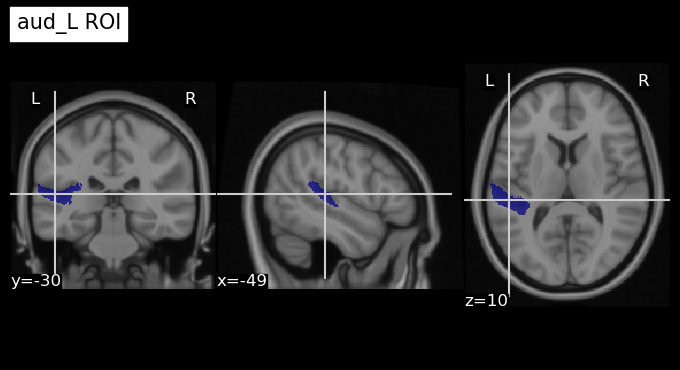

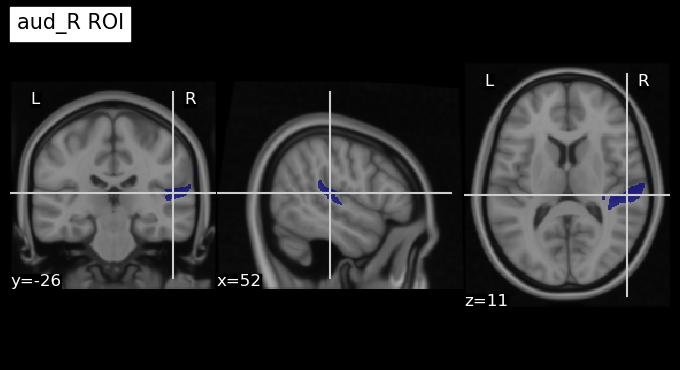

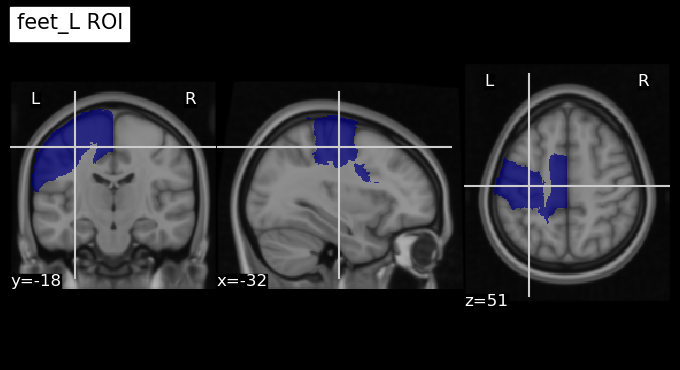

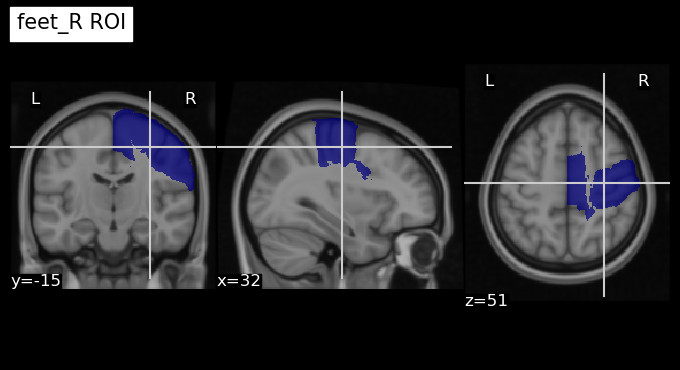

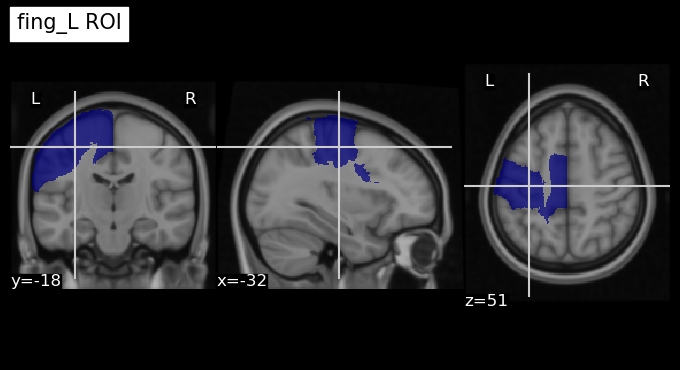

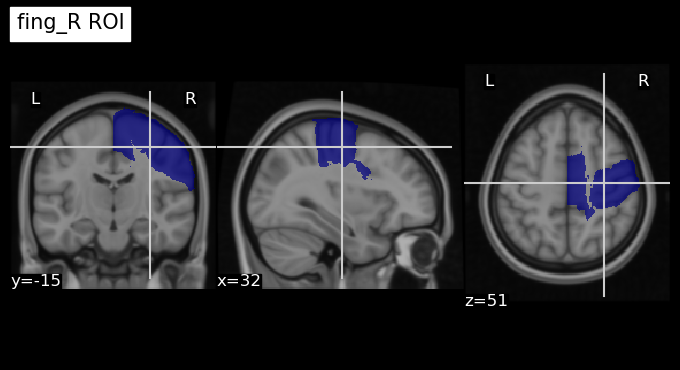

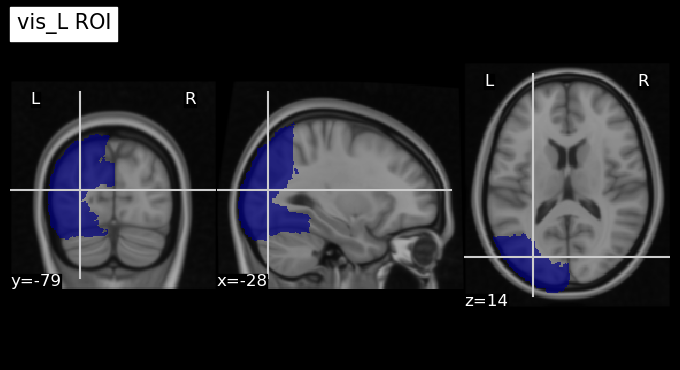

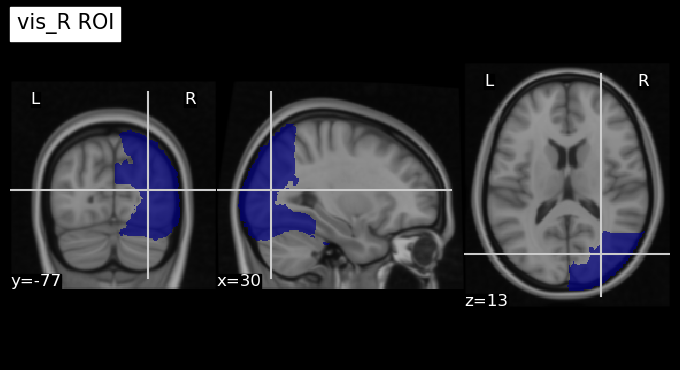

In [33]:
# Define the output directory for the ROIs
roi_outdir = Path(local_dir) / 'derivatives' / f'atlas-{atlas}' / 'rois'
roi_outdir.mkdir(parents=True, exist_ok=True)

# Create and save each ROI
for task, rois in Tasks_ParcelIndices.items():
    # Define the path for saving the ROI
    if atlas != 'AAL':
        roi_path = roi_outdir / f"tpl-MNI152NLin6Asym_res-01_atlas-{atlas}_roi-{task}.nii.gz"
    else:
         roi_path = roi_outdir / f"tpl-MNI152_res-01_atlas-{atlas}_roi-{task}.nii.gz"

    # Create and save the ROI image if not done before
    if not roi_path.exists():
        # Create ROI data
        roi_data = create_roi(atlas_img.get_fdata(), Tasks_ParcelIndices[task])
    
        # Convert to NiftiImage
        roi_img = new_img_like(atlas_img, roi_data)

        # Save
        nib.save(roi_img, roi_path)
        
    else:
        roi_img = nib.load(roi_path)

    # Optionally plot the ROI (uncomment if needed)
    plot_roi(
        roi_img,
        bg_img=tplMNI152NLin6Asym,
        title=f'{task} ROI',
        display_mode='ortho',
        draw_cross=True
    )

    plt.show()
    plt.close()

## Pass the resampled atlas in the subject space

I:\9008_CBT_HNP\MEG-EEG-fMRI\dataset_bids\derivatives_2\sub-03\anat\transform_xfm\ants_template_to_sub-03_Composite.h5
Transformed atlas saved to: I:\9008_CBT_HNP\MEG-EEG-fMRI\dataset_bids\derivatives_2\sub-03\anat\atlas-HOCPAL_desc-th0_dseg\sub-03_atlas-HOCPAL_desc-th0_dseg.nii.gz


C:\Users\lilia.ponselle\AppData\Local\anaconda3\envs\mne\Lib\site-packages\nilearn\image\resampling.py:809: UserWarning: Casting data from int16 to float32
  return resample_img(


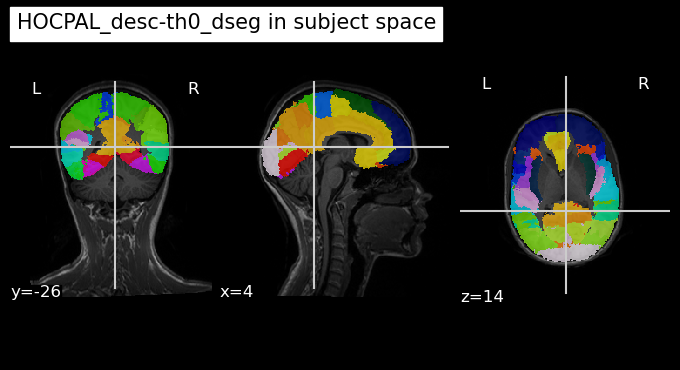

In [34]:
# Define the path to the subject's T1 image in native space
anat_source_path = Path(local_dir) / 'bids' / sub / 'anat'
T1_sub_space_path = anat_source_path / f"{sub}_T1w.nii.gz"

# Define the path for the atlas in subject space
atlas_sub_space_path = atlas_sub_outdir / f"{sub}_atlas-{atlas}.nii.gz"

# Transform the ROI from template to native space
transform_atlas_to_native_space(atlas_sub_temp_space_path, T1_sub_space_path, T1_MNI_path, atlas_sub_space_path, local_dir, sub)

# Optionally plot the resampled atlas in subject space
plot_roi(nib.load(atlas_sub_space_path), bg_img=nib.load(T1_sub_space_path), title=f'{atlas} in subject space', display_mode='ortho', draw_cross=True)
plt.show()
plt.close()

## Now create the ROIs in native space

C:\Users\lilia.ponselle\AppData\Local\anaconda3\envs\mne\Lib\site-packages\nilearn\image\resampling.py:809: UserWarning: Casting data from int16 to float32
  return resample_img(


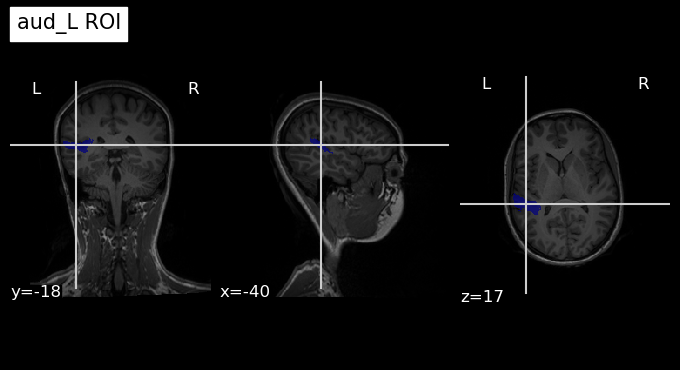

C:\Users\lilia.ponselle\AppData\Local\anaconda3\envs\mne\Lib\site-packages\nilearn\image\resampling.py:809: UserWarning: Casting data from int16 to float32
  return resample_img(


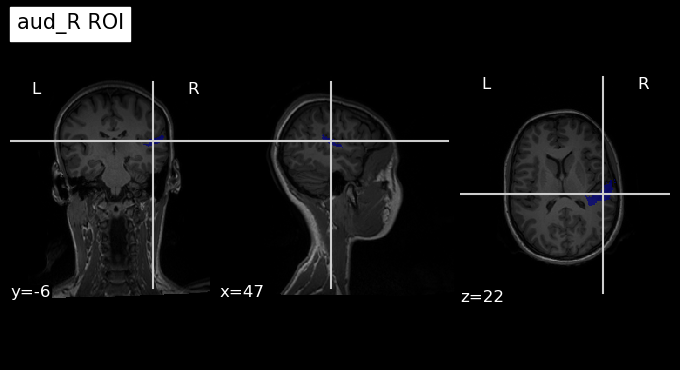

C:\Users\lilia.ponselle\AppData\Local\anaconda3\envs\mne\Lib\site-packages\nilearn\image\resampling.py:809: UserWarning: Casting data from int16 to float32
  return resample_img(


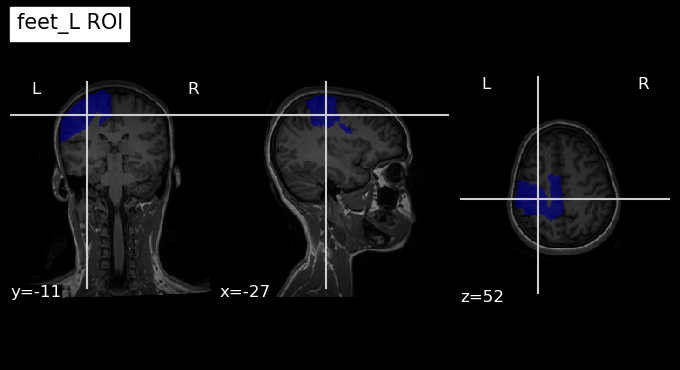

C:\Users\lilia.ponselle\AppData\Local\anaconda3\envs\mne\Lib\site-packages\nilearn\image\resampling.py:809: UserWarning: Casting data from int16 to float32
  return resample_img(


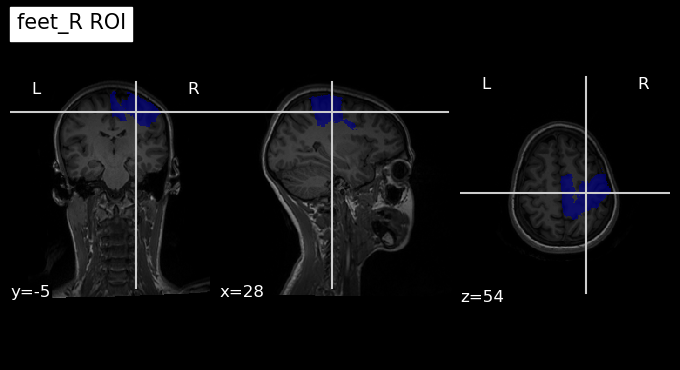

C:\Users\lilia.ponselle\AppData\Local\anaconda3\envs\mne\Lib\site-packages\nilearn\image\resampling.py:809: UserWarning: Casting data from int16 to float32
  return resample_img(


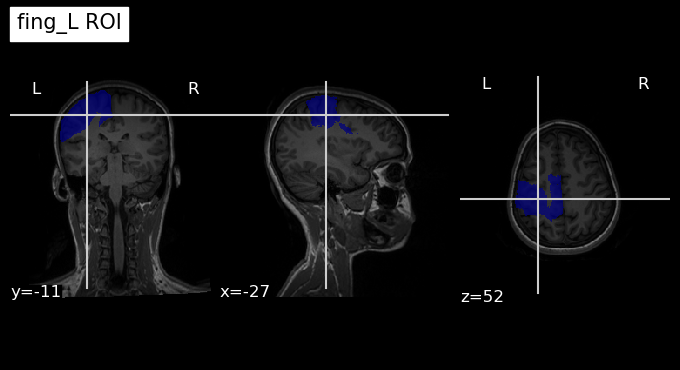

C:\Users\lilia.ponselle\AppData\Local\anaconda3\envs\mne\Lib\site-packages\nilearn\image\resampling.py:809: UserWarning: Casting data from int16 to float32
  return resample_img(


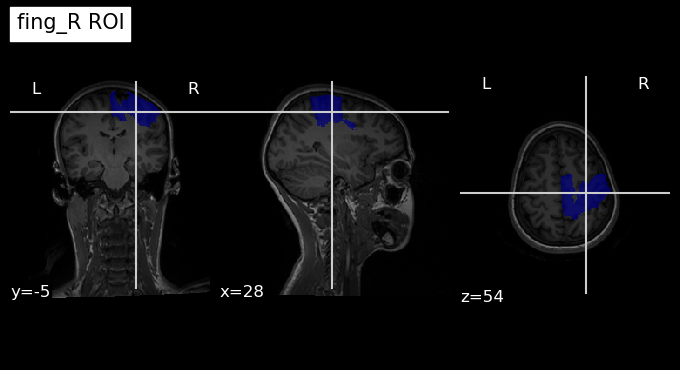

C:\Users\lilia.ponselle\AppData\Local\anaconda3\envs\mne\Lib\site-packages\nilearn\image\resampling.py:809: UserWarning: Casting data from int16 to float32
  return resample_img(


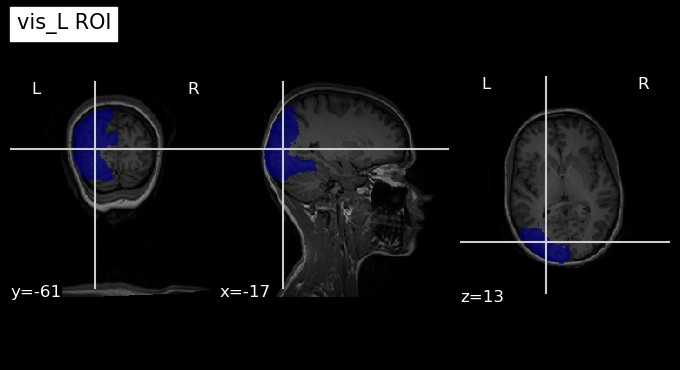

C:\Users\lilia.ponselle\AppData\Local\anaconda3\envs\mne\Lib\site-packages\nilearn\image\resampling.py:809: UserWarning: Casting data from int16 to float32
  return resample_img(


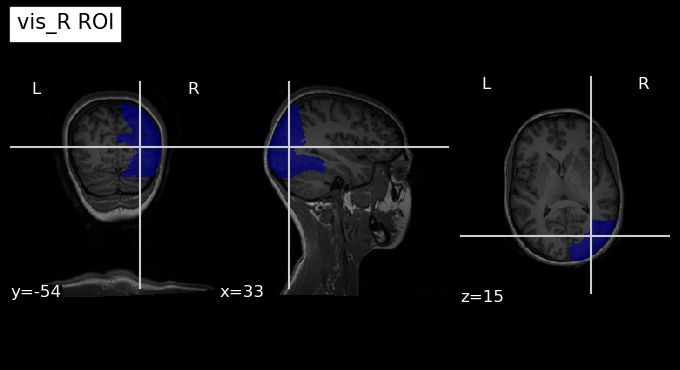

In [35]:
# Define the output directory for the ROIs
roi_sub_outdir = atlas_sub_outdir / 'rois'
roi_sub_outdir.mkdir(parents=True, exist_ok=True)

# Load the resampled atlas in subject space
atlas_sub_space = nib.load(atlas_sub_space_path)

# Create and save each ROI for each task
for task, indices in Tasks_ParcelIndices.items():
    roi_path = roi_sub_outdir / f"{sub}_atlas-{atlas}_roi-{task}.nii.gz"
    
    if not roi_path.exists():
        # Generate the ROI data
        roi_data = create_roi(atlas_sub_space.get_fdata(), indices)
        roi_img = new_img_like(atlas_sub_space, roi_data)
        nib.save(roi_img, roi_path)
    else:
        roi_img = nib.load(roi_path)
    
    # Optionally plot the ROI
    plot_roi(roi_img, bg_img=nib.load(T1_sub_space_path), title=f'{task} ROI', display_mode='ortho', draw_cross=True)
    plt.show()
    plt.close()